In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Per game and advanced data combo

## Load, merge and filter data

In [2]:
per_game = pd.read_csv(Path('../data/per_game_data.csv'))
advanced = pd.read_csv(Path('../data/advanced_data.csv'))
advanced.drop(columns=['MP'], inplace=True)

data = per_game.merge(advanced, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season', 'all_nba_1st_team'])
data.dropna(axis=1, how='all', inplace=True)

data.shape

(8295, 51)

In [3]:
data.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data.drop(columns=['GS'], inplace=True)

data = data[data.G > 40]
data = data[data.MP > 25]

data.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)

data.drop(columns=['TS%'], inplace=True)
data.drop(columns=['WS/48', 'OWS', 'OBPM', 'TRB%', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'USG%'], inplace=True)
data.drop(columns=['G', 'MP'], inplace=True)

data.shape

(2121, 28)

## Split and scale

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['all_nba_1st_team'])
y = data['all_nba_1st_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler

feature_names = X_train.columns

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.dummy import DummyClassifier


def evaluate_model(estimator, X, y):
    y_predicted = estimator.predict(X)
    y_predicted_proba = estimator.predict_proba(X)

    print('confusion matrix:')
    print(confusion_matrix(y, y_predicted))
    print('-------------------------')
    print('classification report:')
    print(classification_report(y, y_predicted))
    print('-------------------------')
    print('roc auc score:', roc_auc_score(y, y_predicted))
    print('-------------------------')
    print('Log loss:', log_loss(y, y_predicted_proba)) # input for log loss are probabilities
    print('-------------------------')


### Without sampling

In [7]:
dummy = DummyClassifier(strategy='stratified', random_state=27)
dummy.fit(X_train, y_train)

print('Train set')
evaluate_model(dummy, X_train, y_train)

print('Test set')
evaluate_model(dummy, X_test, y_test)

Train set
confusion matrix:
[[1369   25]
 [  27    0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1394
           1       0.00      0.00      0.00        27

    accuracy                           0.96      1421
   macro avg       0.49      0.49      0.49      1421
weighted avg       0.96      0.96      0.96      1421

-------------------------
roc auc score: 0.49103299856527977
-------------------------
Log loss: 1.2639101847539458
-------------------------
Test set
confusion matrix:
[[674  13]
 [ 13   0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       687
           1       0.00      0.00      0.00        13

    accuracy                           0.96       700
   macro avg       0.49      0.49      0.49       700
weighted avg       0.96      0.96      0.96       700

-

In [8]:
svc = SVC(kernel='rbf', C=10000, gamma=0.001, probability=True, random_state=27)
svc.fit(X_train, y_train)

print('Train set')
evaluate_model(svc, X_train, y_train)

print('Test set')
evaluate_model(svc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   3   24]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      0.89      0.94        27

    accuracy                           1.00      1421
   macro avg       1.00      0.94      0.97      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 0.9444444444444444
-------------------------
Log loss: 0.04135982869651074
-------------------------
Test set
confusion matrix:
[[680   7]
 [  7   6]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.46      0.46      0.46        13

    accuracy                           0.98       700
   macro avg       0.73      0.73      0.73       700
weighted avg       0.98      0.98      0.98       700

-

In [9]:
rfc = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc.fit(X_train, y_train)

print('Train set')
evaluate_model(rfc, X_train, y_train)

print('Test set')
evaluate_model(rfc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0   27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.012248870455159558
-------------------------
Test set
confusion matrix:
[[687   0]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       687
           1       1.00      0.15      0.27        13

    accuracy                           0.98       700
   macro avg       0.99      0.58      0.63       700
weighted avg       0.98      0.98      0.98       700

---------------

In [10]:
gbc = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=100, random_state=27)
gbc.fit(X_train, y_train)

print('Train set')
evaluate_model(gbc, X_train, y_train)

print('Test set')
evaluate_model(gbc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0   27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 1.1187249864784391e-06
-------------------------
Test set
confusion matrix:
[[681   6]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.33      0.23      0.27        13

    accuracy                           0.98       700
   macro avg       0.66      0.61      0.63       700
weighted avg       0.97      0.98      0.98       700

-------------

## Undersampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1/4
rus = RandomUnderSampler(random_state=27, sampling_strategy=ratio)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_undersampled)

(array([1394,   27]), array([108,  27]))

In [12]:
dummy_undersampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(dummy_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(dummy_undersampling, X_test, y_test)

Train set
confusion matrix:
[[79 29]
 [24  3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       108
           1       0.09      0.11      0.10        27

    accuracy                           0.61       135
   macro avg       0.43      0.42      0.43       135
weighted avg       0.63      0.61      0.62       135

-------------------------
roc auc score: 0.4212962962962963
-------------------------
Log loss: 13.559667769853823
-------------------------
Test set
confusion matrix:
[[539 148]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

----------

In [13]:
svc_undersampling = SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=27)
svc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(svc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(svc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[105   3]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       108
           1       0.90      1.00      0.95        27

    accuracy                           0.98       135
   macro avg       0.95      0.99      0.97       135
weighted avg       0.98      0.98      0.98       135

-------------------------
roc auc score: 0.986111111111111
-------------------------
Log loss: 0.13331014715780334
-------------------------
Test set
confusion matrix:
[[642  45]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       687
           1       0.21      0.92      0.34        13

    accuracy                           0.93       700
   macro avg       0.60      0.93      0.65       700
weighted avg       0.98      0.93      0.95       700

------

In [14]:
rfc_undersampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=150, random_state=27)
rfc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(rfc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(rfc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[108   0]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        27

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.06326589862996387
-------------------------
Test set
confusion matrix:
[[655  32]
 [  0  13]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       687
           1       0.29      1.00      0.45        13

    accuracy                           0.95       700
   macro avg       0.64      0.98      0.71       700
weighted avg       0.99      0.95      0.97       700

--------------------

In [15]:
gbc_undersampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=100, random_state=27)
gbc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(gbc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(gbc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[108   0]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        27

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 1.3840959332909347e-05
-------------------------
Test set
confusion matrix:
[[655  32]
 [  2  11]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       687
           1       0.26      0.85      0.39        13

    accuracy                           0.95       700
   macro avg       0.63      0.90      0.68       700
weighted avg       0.98      0.95      0.96       700

-----------------

## Oversampling

In [16]:
from imblearn.over_sampling import RandomOverSampler

ratio = 1/4
ros = RandomOverSampler(random_state=27, sampling_strategy=ratio)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_oversampled)

(array([1394,   27]), array([1394,  348]))

In [17]:
dummy_oversampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(dummy_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(dummy_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1101  293]
 [ 284   64]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1394
           1       0.18      0.18      0.18       348

    accuracy                           0.67      1742
   macro avg       0.49      0.49      0.49      1742
weighted avg       0.67      0.67      0.67      1742

-------------------------
roc auc score: 0.48686076617358465
-------------------------
Log loss: 11.44022616524883
-------------------------
Test set
confusion matrix:
[[540 147]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

--

In [18]:
svc_oversampling = SVC(kernel='rbf', C=1, gamma='auto', probability=True, random_state=27)
svc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(svc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(svc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1384   10]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1394
           1       0.97      1.00      0.99       348

    accuracy                           0.99      1742
   macro avg       0.99      1.00      0.99      1742
weighted avg       0.99      0.99      0.99      1742

-------------------------
roc auc score: 0.9964131994261118
-------------------------
Log loss: 0.018878799956304048
-------------------------
Test set
confusion matrix:
[[676  11]
 [  3  10]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       687
           1       0.48      0.77      0.59        13

    accuracy                           0.98       700
   macro avg       0.74      0.88      0.79       700
weighted avg       0.99      0.98      0.98       700



In [19]:
rfc_oversampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(rfc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(rfc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00       348

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.008184696620529444
-------------------------
Test set
confusion matrix:
[[687   0]
 [  8   5]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.38      0.56        13

    accuracy                           0.99       700
   macro avg       0.99      0.69      0.77       700
weighted avg       0.99      0.99      0.99       700

---------------

In [20]:
gbc_oversampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=50, random_state=27)
gbc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(gbc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(gbc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00       348

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.002175917200651756
-------------------------
Test set
confusion matrix:
[[685   2]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       687
           1       0.50      0.15      0.24        13

    accuracy                           0.98       700
   macro avg       0.74      0.58      0.61       700
weighted avg       0.98      0.98      0.98       700

---------------

## SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_resampled)

(array([1394,   27]), array([1394, 1394]))

In [22]:
dummy_smote = DummyClassifier(strategy='stratified', random_state=27)
dummy_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(dummy_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(dummy_smote, X_test, y_test)

Train set
confusion matrix:
[[693 701]
 [731 663]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1394
           1       0.49      0.48      0.48      1394

    accuracy                           0.49      2788
   macro avg       0.49      0.49      0.49      2788
weighted avg       0.49      0.49      0.49      2788

-------------------------
roc auc score: 0.4863701578192252
-------------------------
Log loss: 17.740146268835044
-------------------------
Test set
confusion matrix:
[[340 347]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.66       687
           1       0.02      0.54      0.04        13

    accuracy                           0.50       700
   macro avg       0.50      0.52      0.35       700
weighted avg       0.96      0.50      0.65       700

------

In [23]:
svc_smote = SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=27)
svc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(svc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(svc_smote, X_test, y_test)

Train set
confusion matrix:
[[1296   98]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1394
           1       0.93      1.00      0.97      1394

    accuracy                           0.96      2788
   macro avg       0.97      0.96      0.96      2788
weighted avg       0.97      0.96      0.96      2788

-------------------------
roc auc score: 0.9648493543758967
-------------------------
Log loss: 0.08768307835665884
-------------------------
Test set
confusion matrix:
[[639  48]
 [  2  11]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       687
           1       0.19      0.85      0.31        13

    accuracy                           0.93       700
   macro avg       0.59      0.89      0.63       700
weighted avg       0.98      0.93      0.95       700

-

In [24]:
rfc_smote = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100, random_state=27)
rfc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(rfc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(rfc_smote, X_test, y_test)

Train set
confusion matrix:
[[1366   28]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1394
           1       0.98      1.00      0.99      1394

    accuracy                           0.99      2788
   macro avg       0.99      0.99      0.99      2788
weighted avg       0.99      0.99      0.99      2788

-------------------------
roc auc score: 0.9899569583931133
-------------------------
Log loss: 0.03478539002896494
-------------------------
Test set
confusion matrix:
[[671  16]
 [  4   9]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       687
           1       0.36      0.69      0.47        13

    accuracy                           0.97       700
   macro avg       0.68      0.83      0.73       700
weighted avg       0.98      0.97      0.98       700

-

In [25]:
gbc_smote = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=100, random_state=27)
gbc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(gbc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(gbc_smote, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00      1394

    accuracy                           1.00      2788
   macro avg       1.00      1.00      1.00      2788
weighted avg       1.00      1.00      1.00      2788

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 5.5396319314366726e-05
-------------------------
Test set
confusion matrix:
[[682   5]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.44      0.31      0.36        13

    accuracy                           0.98       700
   macro avg       0.72      0.65      0.68       700
weighted avg       0.98      0.98      0.98       700

-------------

## Predict new data (2019-2020 season)

In [26]:
per_game_2020 = pd.read_csv(Path('../data/per_game_2020.csv'))
advanced_2020 = pd.read_csv(Path('../data/advanced_2020.csv'))

advanced_2020.drop(columns=['MP'], inplace=True)

data_2020 = per_game_2020.merge(advanced_2020, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season'])
data_2020.dropna(axis=1, how='all', inplace=True)

# data_2020 = data_2020[data_2020.G > 40]
# data_2020 = data_2020[data_2020.MP > 25]
# data_2020 = data_2020[data_2020.Pos == 'C']
data_2020 = data_2020[data_2020.Player.isin(['Anthony Davis', 'Nikola Jokić', 'Joel Embiid', 'Rudy Gobert'])]

player_names = data_2020['Player'].values
teams = data_2020['Tm'].values

data_2020.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data_2020.drop(columns=['GS'], inplace=True)

data_2020.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)

data_2020.drop(columns=['TS%'], inplace=True)
data_2020.drop(columns=['WS/48', 'OWS', 'OBPM', 'TRB%', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'USG%'], inplace=True)
data_2020.drop(columns=['G', 'MP'], inplace=True)

data_2020 = scaler.transform(data_2020)

data_2020.shape

(4, 27)

In [27]:
svc_predictions = np.around([pred[1] for pred in svc.predict_proba(data_2020)], 3)
rfc_predictions = np.around([pred[1] for pred in rfc.predict_proba(data_2020)], 3)
gbc_predictions = np.around([pred[1] for pred in gbc.predict_proba(data_2020)], 3)

no_sampling_predictions = pd.DataFrame({
    'svc': svc_predictions,
    'rfc': rfc_predictions,
    'gbc': gbc_predictions
})


In [28]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions = pd.DataFrame({
    'svc': svc_undersampling_predictions,
    'rfc': rfc_undersampling_predictions,
    'gbc': gbc_undersampling_predictions
})


In [29]:
svc_oversampling_predictions = np.around([pred[1] for pred in svc_oversampling.predict_proba(data_2020)], 3)
rfc_oversampling_predictions = np.around([pred[1] for pred in rfc_oversampling.predict_proba(data_2020)], 3)
gbc_oversampling_predictions = np.around([pred[1] for pred in gbc_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions = pd.DataFrame({
    'svc': svc_oversampling_predictions,
    'rfc': rfc_oversampling_predictions,
    'gbc': gbc_oversampling_predictions
})


In [30]:
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)
gbc_smote_predictions = np.around([pred[1] for pred in gbc_smote.predict_proba(data_2020)], 3)

smote_predictions = pd.DataFrame({
    'svc': svc_smote_predictions,
    'rfc': rfc_smote_predictions,
    'gbc': gbc_smote_predictions
})


## Voting and averages

In [31]:
no_sampling_predictions['mean pred'] = no_sampling_predictions.mean(axis=1)
undersampling_predictions['mean pred'] = undersampling_predictions.mean(axis=1)
oversampling_predictions['mean pred'] = oversampling_predictions.mean(axis=1)
smote_predictions['mean pred'] = smote_predictions.mean(axis=1)

In [32]:
from sklearn.ensemble import VotingClassifier

In [33]:
voting = VotingClassifier(
    [('svc', svc), ('rfc', rfc), ('gbc', gbc)],
    voting='soft',
    weights=[4.6 + 7.3, 1.5 + 5.8, 2.3 + 6.1]
).fit(X_train, y_train)

probs = np.round([prob[1] for prob in voting.predict_proba(data_2020)], 3)

no_sampling_predictions['voting pred'] = probs

In [34]:
no_sampling_predictions['player'] = player_names
no_sampling_predictions['team'] = teams

no_sampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.297,0.14,0.0,0.145667,0.165,Anthony Davis,LAL
1,0.059,0.02,0.0,0.026333,0.031,Joel Embiid,PHI
2,0.064,0.12,0.0,0.061333,0.059,Rudy Gobert,UTA
3,0.008,0.00,0.0,0.002667,0.004,Nikola Jokić,DEN


In [35]:
voting_undersampling = VotingClassifier(
    [('svc', svc_undersampling), ('rfc', rfc_undersampling), ('gbc', gbc_undersampling)],
    voting='soft',
    weights=[9.3 + 9.2, 9.0 + 8.5, 8.6 + 7.7]
).fit(X_train_undersampled, y_train_undersampled)

probs = np.round([prob[1] for prob in voting_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions['voting pred'] = probs

In [36]:
undersampling_predictions['player'] = player_names
undersampling_predictions['team'] = teams

undersampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.488,0.547,0.116,0.383667,0.392,Anthony Davis,LAL
1,0.143,0.220,0.000,0.121000,0.124,Joel Embiid,PHI
2,0.605,0.447,0.349,0.467000,0.472,Rudy Gobert,UTA
3,0.346,0.413,0.010,0.256333,0.264,Nikola Jokić,DEN


In [37]:
voting_oversampling = VotingClassifier(
    [('svc', svc_oversampling), ('rfc', rfc_oversampling), ('gbc', gbc_oversampling)],
    voting='soft',
    weights=[8.4 + 6.9, 6.2 + 2.3, 6.1 + 2.3] # rac aur + recall
).fit(X_train_oversampled, y_train_oversampled)

probs = np.round([prob[1] for prob in voting_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions['voting pred'] = probs

In [38]:
oversampling_predictions['player'] = player_names
oversampling_predictions['team'] = teams

oversampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.106,0.158,0.204,0.156000,0.145,Anthony Davis,LAL
1,0.000,0.000,0.001,0.000333,0.000,Joel Embiid,PHI
2,0.002,0.180,0.001,0.061000,0.049,Rudy Gobert,UTA
3,0.000,0.020,0.001,0.007000,0.006,Nikola Jokić,DEN


In [39]:
voting_smote = VotingClassifier(
    [('svc', svc_smote), ('rfc', rfc_smote), ('gbc', gbc_smote)],
    voting='soft',
    weights=[8.9 + 8.5, 8.3 + 6.9, 6.1 + 2.3]
).fit(X_train_resampled, y_train_resampled)

probs = np.round([prob[1] for prob in voting_smote.predict_proba(data_2020)], 3)

smote_predictions['voting pred'] = probs

In [40]:
smote_predictions['player'] = player_names
smote_predictions['team'] = teams

smote_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.189,0.207,0.029,0.141667,0.163,Anthony Davis,LAL
1,0.004,0.070,0.000,0.024667,0.027,Joel Embiid,PHI
2,0.311,0.617,0.119,0.349000,0.385,Rudy Gobert,UTA
3,0.001,0.030,0.000,0.010333,0.012,Nikola Jokić,DEN


### Averaging best models

In [41]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)
svc_oversampling_predictions = np.around([pred[1] for pred in svc_oversampling.predict_proba(data_2020)], 3)
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)

best_models_predictions = pd.DataFrame({
    'svc_undersampling': svc_undersampling_predictions,
    'rfc_undersampling': rfc_undersampling_predictions,
    'gbc_undersampling': gbc_undersampling_predictions,
    'svc_oversampling': svc_oversampling_predictions,
    'svc_smote': svc_smote_predictions,
    'rfc_smote': rfc_smote_predictions
})

best_models_predictions['mean pred'] = best_models_predictions.mean(axis=1)
best_models_predictions['player'] = player_names

best_models_predictions

,svc_undersampling,rfc_undersampling,gbc_undersampling,svc_oversampling,svc_smote,rfc_smote,mean pred,player
0,0.488,0.547,0.116,0.106,0.189,0.207,0.275500,Anthony Davis
1,0.143,0.220,0.000,0.000,0.004,0.070,0.072833,Joel Embiid
2,0.605,0.447,0.349,0.002,0.311,0.617,0.388500,Rudy Gobert
3,0.346,0.413,0.010,0.000,0.001,0.030,0.133333,Nikola Jokić


## SHAP values

In [42]:
import shap
import matplotlib.pyplot as plt

def SHAP_values(model, X_train):
    k_sample = shap.kmeans(X_train, 5)
    explainer = shap.KernelExplainer(model.predict, k_sample)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)
    plt.show()

    shap.summary_plot(shap_values, X_train, plot_type='bar')
    plt.show()


In [43]:
# SHAP_values(svc, pd.DataFrame(data=X_train, columns=feature_names))

In [44]:
# SHAP_values(rfc, pd.DataFrame(data=X_train, columns=feature_names))

In [45]:
# SHAP_values(gbc, pd.DataFrame(data=X_train, columns=feature_names))

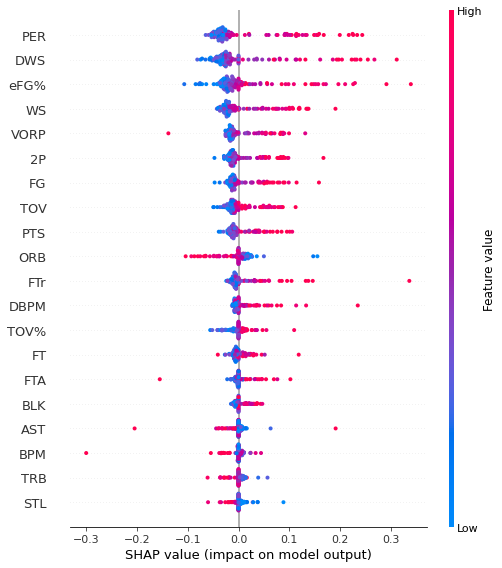

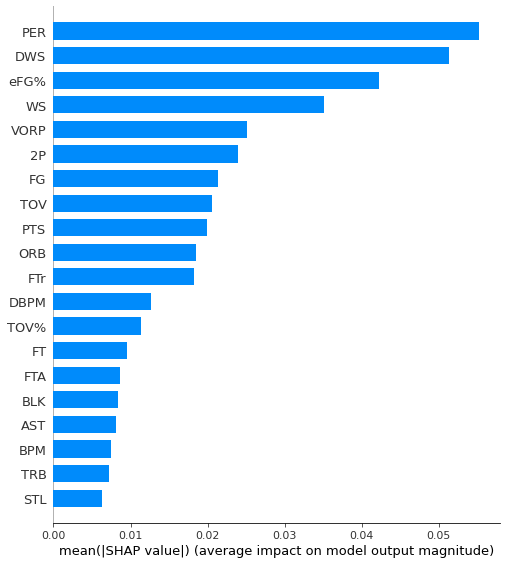

In [46]:
SHAP_values(svc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

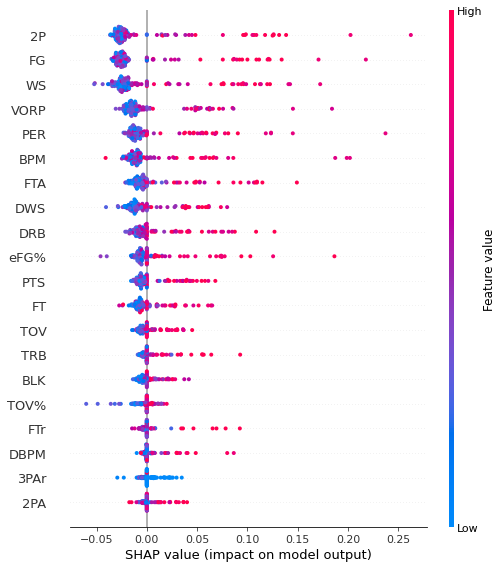

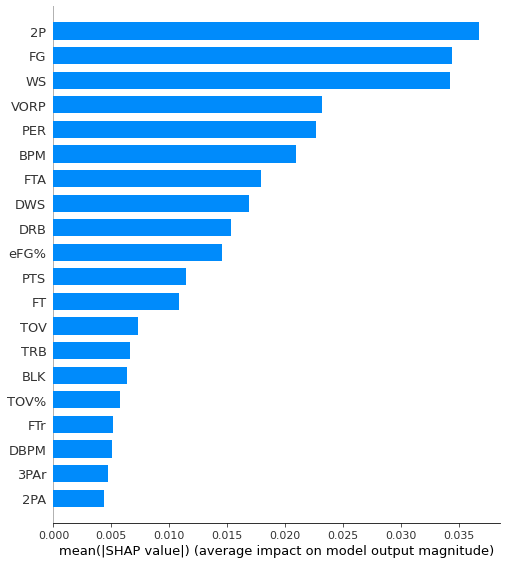

In [47]:
SHAP_values(rfc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

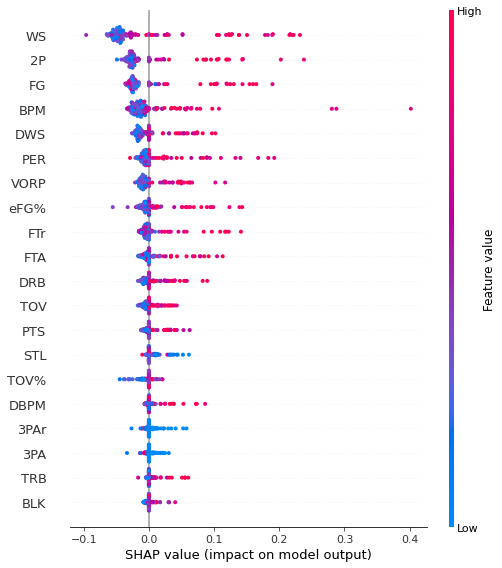

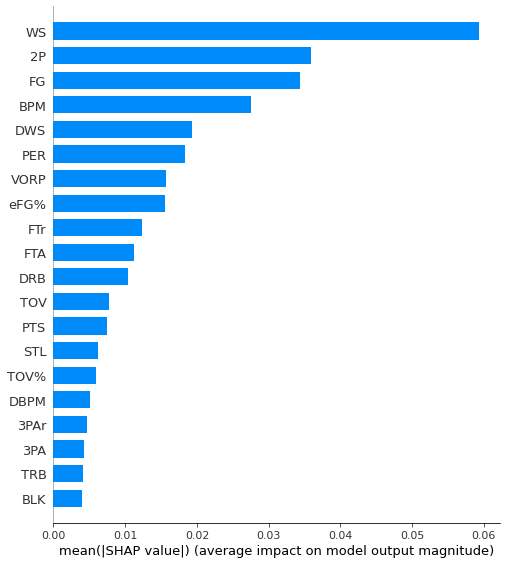

In [48]:
SHAP_values(gbc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

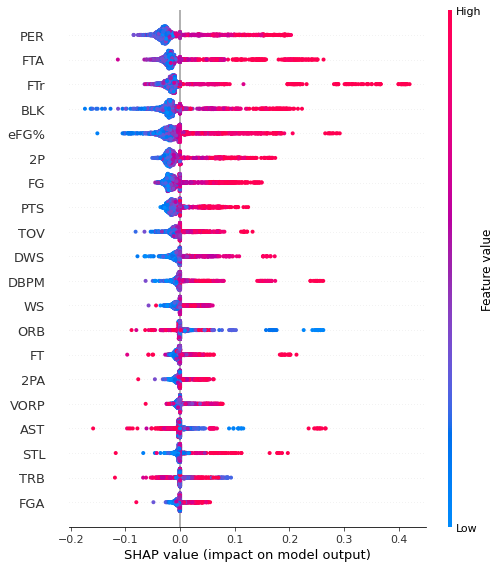

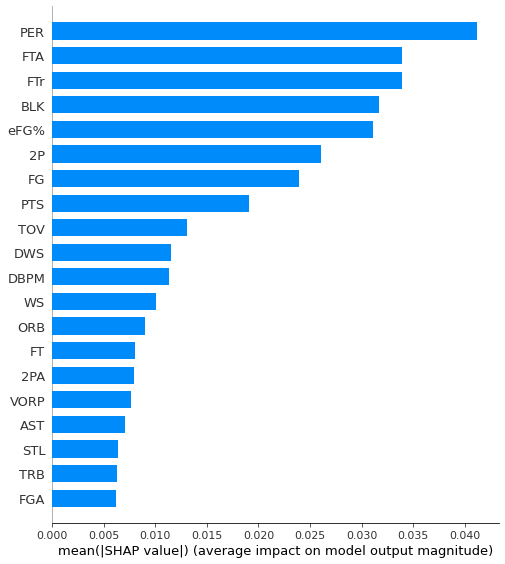

In [49]:
SHAP_values(svc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [50]:
# SHAP_values(rfc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [51]:
# SHAP_values(gbc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

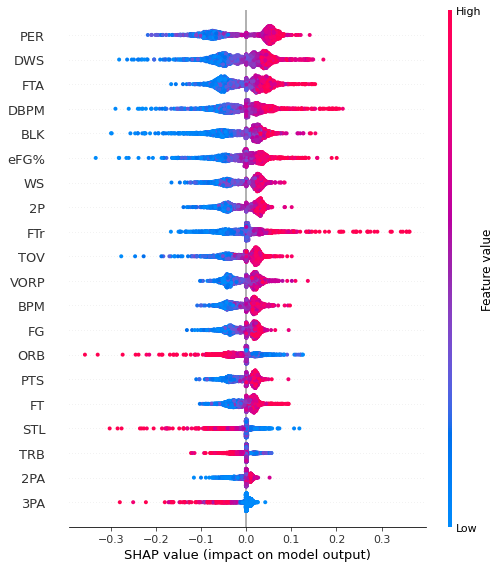

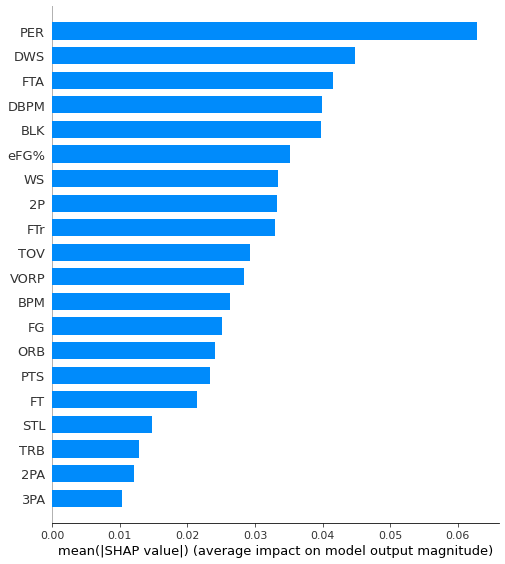

In [52]:
SHAP_values(svc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

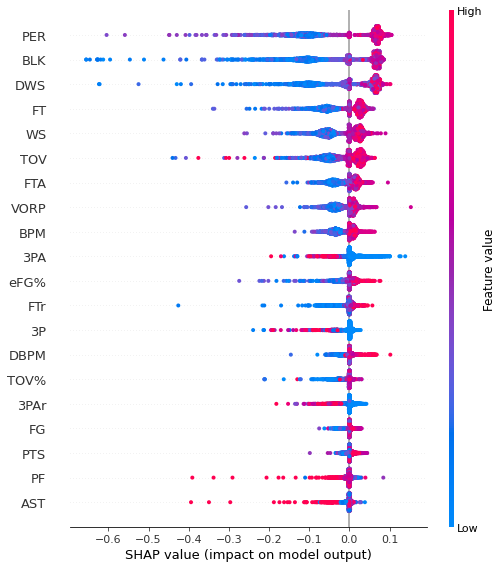

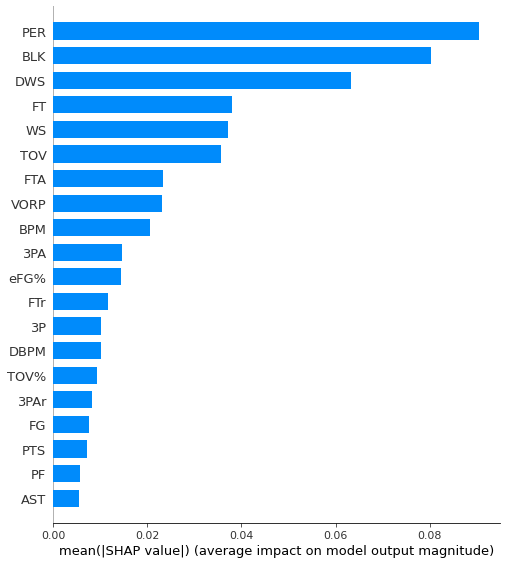

In [53]:
SHAP_values(rfc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

In [54]:
# SHAP_values(gbc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

# Per 100 and advanced data combo

# Load, merge and filter data

In [55]:
per_poss = pd.read_csv(Path('../data/per_100_data.csv'))
advanced = pd.read_csv(Path('../data/advanced_data.csv'))

data = per_poss.merge(advanced, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'season', 'all_nba_1st_team'])
data.dropna(axis=1, how='all', inplace=True)

# transfer minutes to per game stat instead of season total
data['MP'] = np.round(data['MP'] / data['G'], 1)

data.shape

(8295, 52)

In [56]:
data.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data.drop(columns=['GS'], inplace=True)

data = data[data.G > 40]
data = data[data.MP > 25]

data.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)

data.drop(columns=['WS/48', 'OWS', 'OBPM', 'TRB%', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'USG%'], inplace=True)
data.drop(columns=['G', 'MP'], inplace=True)

data.shape

(2121, 30)

## Split and scale

In [57]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['all_nba_1st_team'])
y = data['all_nba_1st_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27, stratify=y)

In [58]:
from sklearn.preprocessing import StandardScaler

feature_names = X_train.columns

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.dummy import DummyClassifier


def evaluate_model(estimator, X, y):
    y_predicted = estimator.predict(X)
    y_predicted_proba = estimator.predict_proba(X)

    print('confusion matrix:')
    print(confusion_matrix(y, y_predicted))
    print('-------------------------')
    print('classification report:')
    print(classification_report(y, y_predicted))
    print('-------------------------')
    print('roc auc score:', roc_auc_score(y, y_predicted))
    print('-------------------------')
    print('Log loss:', log_loss(y, y_predicted_proba)) # input for log loss are probabilities
    print('-------------------------')


### Without sampling

In [60]:
dummy = DummyClassifier(strategy='stratified', random_state=27)
dummy.fit(X_train, y_train)

print('Train set')
evaluate_model(dummy, X_train, y_train)

print('Test set')
evaluate_model(dummy, X_test, y_test)

Train set
confusion matrix:
[[1369   25]
 [  27    0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1394
           1       0.00      0.00      0.00        27

    accuracy                           0.96      1421
   macro avg       0.49      0.49      0.49      1421
weighted avg       0.96      0.96      0.96      1421

-------------------------
roc auc score: 0.49103299856527977
-------------------------
Log loss: 1.2639101847539458
-------------------------
Test set
confusion matrix:
[[674  13]
 [ 13   0]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       687
           1       0.00      0.00      0.00        13

    accuracy                           0.96       700
   macro avg       0.49      0.49      0.49       700
weighted avg       0.96      0.96      0.96       700

-

In [61]:
svc = SVC(kernel='rbf', C=100, gamma=0.1, probability=True, random_state=27)
svc.fit(X_train, y_train)

print('Train set')
evaluate_model(svc, X_train, y_train)

print('Test set')
evaluate_model(svc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0   27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.011992606990646247
-------------------------
Test set
confusion matrix:
[[686   1]
 [  8   5]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       0.83      0.38      0.53        13

    accuracy                           0.99       700
   macro avg       0.91      0.69      0.76       700
weighted avg       0.99      0.99      0.98       700

---------------

In [62]:
rfc = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc.fit(X_train, y_train)

print('Train set')
evaluate_model(rfc, X_train, y_train)

print('Test set')
evaluate_model(rfc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0   27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.011351007063975174
-------------------------
Test set
confusion matrix:
[[687   0]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.23      0.38        13

    accuracy                           0.99       700
   macro avg       0.99      0.62      0.68       700
weighted avg       0.99      0.99      0.98       700

---------------

In [63]:
gbc = GradientBoostingClassifier(loss='deviance', max_depth=20, max_features=None, n_estimators=100, random_state=27)
gbc.fit(X_train, y_train)

print('Train set')
evaluate_model(gbc, X_train, y_train)

print('Test set')
evaluate_model(gbc, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0   27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00        27

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 1.0441610498237941e-06
-------------------------
Test set
confusion matrix:
[[677  10]
 [ 10   3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.23      0.23      0.23        13

    accuracy                           0.97       700
   macro avg       0.61      0.61      0.61       700
weighted avg       0.97      0.97      0.97       700

-------------

## Undersampling

In [64]:
from imblearn.under_sampling import RandomUnderSampler

ratio = 1/4
rus = RandomUnderSampler(random_state=27, sampling_strategy=ratio)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_undersampled)

(array([1394,   27]), array([108,  27]))

In [65]:
dummy_undersampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(dummy_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(dummy_undersampling, X_test, y_test)

Train set
confusion matrix:
[[79 29]
 [24  3]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       108
           1       0.09      0.11      0.10        27

    accuracy                           0.61       135
   macro avg       0.43      0.42      0.43       135
weighted avg       0.63      0.61      0.62       135

-------------------------
roc auc score: 0.4212962962962963
-------------------------
Log loss: 13.559667769853823
-------------------------
Test set
confusion matrix:
[[539 148]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

----------

In [66]:
svc_undersampling = SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=27)
svc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(svc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(svc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[105   3]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       108
           1       0.90      1.00      0.95        27

    accuracy                           0.98       135
   macro avg       0.95      0.99      0.97       135
weighted avg       0.98      0.98      0.98       135

-------------------------
roc auc score: 0.986111111111111
-------------------------
Log loss: 0.1222040554755357
-------------------------
Test set
confusion matrix:
[[634  53]
 [  1  12]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       687
           1       0.18      0.92      0.31        13

    accuracy                           0.92       700
   macro avg       0.59      0.92      0.63       700
weighted avg       0.98      0.92      0.95       700

-------

In [67]:
rfc_undersampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(rfc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(rfc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[108   0]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        27

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.06298172174505086
-------------------------
Test set
confusion matrix:
[[649  38]
 [  0  13]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       687
           1       0.25      1.00      0.41        13

    accuracy                           0.95       700
   macro avg       0.63      0.97      0.69       700
weighted avg       0.99      0.95      0.96       700

--------------------

In [68]:
gbc_undersampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=100, random_state=27)
gbc_undersampling.fit(X_train_undersampled, y_train_undersampled)

print('Train set')
evaluate_model(gbc_undersampling, X_train_undersampled, y_train_undersampled)

print('Test set')
evaluate_model(gbc_undersampling, X_test, y_test)

Train set
confusion matrix:
[[108   0]
 [  0  27]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        27

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 1.3840959332909347e-05
-------------------------
Test set
confusion matrix:
[[661  26]
 [  0  13]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       687
           1       0.33      1.00      0.50        13

    accuracy                           0.96       700
   macro avg       0.67      0.98      0.74       700
weighted avg       0.99      0.96      0.97       700

-----------------

## Oversampling

In [69]:
from imblearn.over_sampling import RandomOverSampler

ratio = 1/4
ros = RandomOverSampler(random_state=27, sampling_strategy=ratio)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_oversampled)

(array([1394,   27]), array([1394,  348]))

In [70]:
dummy_oversampling = DummyClassifier(strategy='stratified', random_state=27)
dummy_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(dummy_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(dummy_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1101  293]
 [ 284   64]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1394
           1       0.18      0.18      0.18       348

    accuracy                           0.67      1742
   macro avg       0.49      0.49      0.49      1742
weighted avg       0.67      0.67      0.67      1742

-------------------------
roc auc score: 0.48686076617358465
-------------------------
Log loss: 11.44022616524883
-------------------------
Test set
confusion matrix:
[[540 147]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       687
           1       0.01      0.15      0.02        13

    accuracy                           0.77       700
   macro avg       0.50      0.47      0.45       700
weighted avg       0.96      0.77      0.86       700

--

In [71]:
svc_oversampling = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=27)
svc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(svc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(svc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1371   23]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1394
           1       0.94      1.00      0.97       348

    accuracy                           0.99      1742
   macro avg       0.97      0.99      0.98      1742
weighted avg       0.99      0.99      0.99      1742

-------------------------
roc auc score: 0.9917503586800575
-------------------------
Log loss: 0.03222999381332019
-------------------------
Test set
confusion matrix:
[[671  16]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       687
           1       0.30      0.54      0.39        13

    accuracy                           0.97       700
   macro avg       0.65      0.76      0.69       700
weighted avg       0.98      0.97      0.97       700

-

In [72]:
rfc_oversampling = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50 , random_state=27)
rfc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(rfc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(rfc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1392    2]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       0.99      1.00      1.00       348

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742

-------------------------
roc auc score: 0.9992826398852224
-------------------------
Log loss: 0.011881844127832065
-------------------------
Test set
confusion matrix:
[[685   2]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       0.67      0.31      0.42        13

    accuracy                           0.98       700
   macro avg       0.83      0.65      0.71       700
weighted avg       0.98      0.98      0.98       700



In [73]:
gbc_oversampling = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features=None, n_estimators=50, random_state=27)
gbc_oversampling.fit(X_train_oversampled, y_train_oversampled)

print('Train set')
evaluate_model(gbc_oversampling, X_train_oversampled, y_train_oversampled)

print('Test set')
evaluate_model(gbc_oversampling, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0  348]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00       348

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.002202293022626951
-------------------------
Test set
confusion matrix:
[[678   9]
 [ 11   2]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       687
           1       0.18      0.15      0.17        13

    accuracy                           0.97       700
   macro avg       0.58      0.57      0.58       700
weighted avg       0.97      0.97      0.97       700

---------------

## SMOTE

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=27, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

np.bincount(y_train), np.bincount(y_train_resampled)

(array([1394,   27]), array([1394, 1394]))

In [75]:
dummy_smote = DummyClassifier(strategy='stratified', random_state=27)
dummy_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(dummy_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(dummy_smote, X_test, y_test)

Train set
confusion matrix:
[[693 701]
 [731 663]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1394
           1       0.49      0.48      0.48      1394

    accuracy                           0.49      2788
   macro avg       0.49      0.49      0.49      2788
weighted avg       0.49      0.49      0.49      2788

-------------------------
roc auc score: 0.4863701578192252
-------------------------
Log loss: 17.740146268835044
-------------------------
Test set
confusion matrix:
[[340 347]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.66       687
           1       0.02      0.54      0.04        13

    accuracy                           0.50       700
   macro avg       0.50      0.52      0.35       700
weighted avg       0.96      0.50      0.65       700

------

In [76]:
svc_smote = SVC(kernel='rbf', C=0.1, gamma=0.1, probability=True, random_state=27)
svc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(svc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(svc_smote, X_test, y_test)

Train set
confusion matrix:
[[1363   31]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1394
           1       0.98      1.00      0.99      1394

    accuracy                           0.99      2788
   macro avg       0.99      0.99      0.99      2788
weighted avg       0.99      0.99      0.99      2788

-------------------------
roc auc score: 0.9888809182209469
-------------------------
Log loss: 0.011110467486409073
-------------------------
Test set
confusion matrix:
[[670  17]
 [  6   7]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       687
           1       0.29      0.54      0.38        13

    accuracy                           0.97       700
   macro avg       0.64      0.76      0.68       700
weighted avg       0.98      0.97      0.97       700



In [77]:
rfc_smote = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=50, random_state=27)
rfc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(rfc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(rfc_smote, X_test, y_test)

Train set
confusion matrix:
[[1370   24]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1394
           1       0.98      1.00      0.99      1394

    accuracy                           0.99      2788
   macro avg       0.99      0.99      0.99      2788
weighted avg       0.99      0.99      0.99      2788

-------------------------
roc auc score: 0.9913916786226686
-------------------------
Log loss: 0.03482032367605419
-------------------------
Test set
confusion matrix:
[[674  13]
 [  5   8]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       687
           1       0.38      0.62      0.47        13

    accuracy                           0.97       700
   macro avg       0.69      0.80      0.73       700
weighted avg       0.98      0.97      0.98       700

-

In [78]:
gbc_smote = GradientBoostingClassifier(loss='deviance', max_depth=10, max_features='sqrt', n_estimators=50, random_state=27)
gbc_smote.fit(X_train_resampled, y_train_resampled)

print('Train set')
evaluate_model(gbc_smote, X_train_resampled, y_train_resampled)

print('Test set')
evaluate_model(gbc_smote, X_test, y_test)

Train set
confusion matrix:
[[1394    0]
 [   0 1394]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00      1394

    accuracy                           1.00      2788
   macro avg       1.00      1.00      1.00      2788
weighted avg       1.00      1.00      1.00      2788

-------------------------
roc auc score: 1.0
-------------------------
Log loss: 0.005573994871198722
-------------------------
Test set
confusion matrix:
[[679   8]
 [  9   4]]
-------------------------
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       687
           1       0.33      0.31      0.32        13

    accuracy                           0.98       700
   macro avg       0.66      0.65      0.65       700
weighted avg       0.97      0.98      0.98       700

---------------

## Predict new data (2019-2020 season)

In [79]:
per_game_2020 = pd.read_csv(Path('../data/per_100_2020.csv'))
advanced_2020 = pd.read_csv(Path('../data/advanced_2020.csv'))

advanced_2020.drop(columns=['MP'], inplace=True)

data_2020 = per_game_2020.merge(advanced_2020, on=['Player', 'Pos', 'Age', 'Tm', 'G', 'season'])
data_2020.dropna(axis=1, how='all', inplace=True)

data_2020['MP'] = np.round(data_2020['MP'] / data_2020['G'], 1)

data_2020 = data_2020[data_2020.G > 40]
data_2020 = data_2020[data_2020.MP > 25]
# data_2020 = data_2020[data_2020.Pos == 'C']
data_2020 = data_2020[data_2020.Player.isin(['Anthony Davis', 'Nikola Jokić', 'Joel Embiid', 'Rudy Gobert'])]

player_names = data_2020['Player'].values
teams = data_2020['Tm'].values

data_2020.drop(columns=['Player', 'Pos', 'Age', 'Tm', 'season'], inplace=True)
data_2020.drop(columns=['GS'], inplace=True)

data_2020.drop(columns=['FG%', '2P%', '3P%', 'FT%'], inplace=True)

data_2020.drop(columns=['WS/48', 'OWS', 'OBPM', 'TRB%', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'USG%'], inplace=True)
data_2020.drop(columns=['G', 'MP'], inplace=True)

data_2020 = scaler.transform(data_2020)

data_2020.shape

(4, 29)

In [80]:
svc_predictions = np.around([pred[1] for pred in svc.predict_proba(data_2020)], 3)
rfc_predictions = np.around([pred[1] for pred in rfc.predict_proba(data_2020)], 3)
gbc_predictions = np.around([pred[1] for pred in gbc.predict_proba(data_2020)], 3)

no_sampling_predictions = pd.DataFrame({
    'svc': svc_predictions,
    'rfc': rfc_predictions,
    'gbc': gbc_predictions
})


In [81]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions = pd.DataFrame({
    'svc': svc_undersampling_predictions,
    'rfc': rfc_undersampling_predictions,
    'gbc': gbc_undersampling_predictions
})


In [82]:
svc_oversampling_predictions = np.around([pred[1] for pred in svc_oversampling.predict_proba(data_2020)], 3)
rfc_oversampling_predictions = np.around([pred[1] for pred in rfc_oversampling.predict_proba(data_2020)], 3)
gbc_oversampling_predictions = np.around([pred[1] for pred in gbc_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions = pd.DataFrame({
    'svc': svc_oversampling_predictions,
    'rfc': rfc_oversampling_predictions,
    'gbc': gbc_oversampling_predictions
})


In [83]:
svc_smote_predictions = np.around([pred[1] for pred in svc_smote.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)
gbc_smote_predictions = np.around([pred[1] for pred in gbc_smote.predict_proba(data_2020)], 3)

smote_predictions = pd.DataFrame({
    'svc': svc_smote_predictions,
    'rfc': rfc_smote_predictions,
    'gbc': gbc_smote_predictions
})


## Voting and averages

In [84]:
no_sampling_predictions['mean pred'] = no_sampling_predictions.mean(axis=1)
undersampling_predictions['mean pred'] = undersampling_predictions.mean(axis=1)
oversampling_predictions['mean pred'] = oversampling_predictions.mean(axis=1)
smote_predictions['mean pred'] = smote_predictions.mean(axis=1)

In [85]:
from sklearn.ensemble import VotingClassifier

In [86]:
voting = VotingClassifier(
    [('svc', svc), ('rfc', rfc), ('gbc', gbc)],
    voting='soft',
    weights=[3.8 + 6.9, 2.3 + 6.1, 2.3 + 6.1]
).fit(X_train, y_train)

probs = np.round([prob[1] for prob in voting.predict_proba(data_2020)], 3)

no_sampling_predictions['voting pred'] = probs

In [87]:
no_sampling_predictions['player'] = player_names
no_sampling_predictions['team'] = teams

no_sampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.061,0.100,0.0,0.053667,0.054,Anthony Davis,LAL
1,0.020,0.100,0.0,0.040000,0.038,Joel Embiid,PHI
2,0.015,0.020,0.0,0.011667,0.012,Rudy Gobert,UTA
3,0.017,0.004,0.0,0.007000,0.008,Nikola Jokić,DEN


In [88]:
voting_undersampling = VotingClassifier(
    [('svc', svc_undersampling), ('rfc', rfc_undersampling), ('gbc', gbc_undersampling)],
    voting='soft',
    weights=[8.5 + 8.8, 9.2 + 9.3, 8.5 + 9.0]
).fit(X_train_undersampled, y_train_undersampled)

probs = np.round([prob[1] for prob in voting_undersampling.predict_proba(data_2020)], 3)

undersampling_predictions['voting pred'] = probs

In [89]:
undersampling_predictions['player'] = player_names
undersampling_predictions['team'] = teams

undersampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.500,0.62,0.335,0.485000,0.488,Anthony Davis,LAL
1,0.234,0.40,0.007,0.213667,0.217,Joel Embiid,PHI
2,0.454,0.32,0.001,0.258333,0.259,Rudy Gobert,UTA
3,0.312,0.48,0.054,0.282000,0.286,Nikola Jokić,DEN


In [90]:
voting_oversampling = VotingClassifier(
    [('svc', svc_oversampling), ('rfc', rfc_oversampling), ('gbc', gbc_oversampling)],
    voting='soft',
    weights=[6.2 + 7.9, 3.1 + 6.5, 3.8 + 6.8]
).fit(X_train_oversampled, y_train_oversampled)

probs = np.round([prob[1] for prob in voting_oversampling.predict_proba(data_2020)], 3)

oversampling_predictions['voting pred'] = probs

In [91]:
oversampling_predictions['player'] = player_names
oversampling_predictions['team'] = teams

oversampling_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.226,0.257,0.880,0.454333,0.437,Anthony Davis,LAL
1,0.004,0.099,0.001,0.034667,0.030,Joel Embiid,PHI
2,0.000,0.057,0.001,0.019333,0.017,Rudy Gobert,UTA
3,0.000,0.000,0.001,0.000333,0.001,Nikola Jokić,DEN


In [92]:
voting_smote = VotingClassifier(
    [('svc', svc_smote), ('rfc', rfc_smote), ('gbc', gbc_smote)],
    voting='soft',
    weights=[9.2 + 9.3, 5.4 + 7.5, 2.3 + 6.0]
).fit(X_train_resampled, y_train_resampled)

probs = np.round([prob[1] for prob in voting_smote.predict_proba(data_2020)], 3)

smote_predictions['voting pred'] = probs

In [93]:
smote_predictions['player'] = player_names
smote_predictions['team'] = teams

smote_predictions

,svc,rfc,gbc,mean pred,voting pred,player,team
0,0.0,0.246,0.105,0.117000,0.102,Anthony Davis,LAL
1,0.0,0.100,0.029,0.043000,0.038,Joel Embiid,PHI
2,0.0,0.180,0.019,0.066333,0.062,Rudy Gobert,UTA
3,0.0,0.040,0.014,0.018000,0.016,Nikola Jokić,DEN


### Averaging best models

In [94]:
svc_undersampling_predictions = np.around([pred[1] for pred in svc_undersampling.predict_proba(data_2020)], 3)
rfc_undersampling_predictions = np.around([pred[1] for pred in rfc_undersampling.predict_proba(data_2020)], 3)
gbc_undersampling_predictions = np.around([pred[1] for pred in gbc_undersampling.predict_proba(data_2020)], 3)
rfc_smote_predictions = np.around([pred[1] for pred in rfc_smote.predict_proba(data_2020)], 3)

best_models_predictions = pd.DataFrame({
    'svc_undersampling': svc_undersampling_predictions,
    'rfc_undersampling': rfc_undersampling_predictions,
    'gbc_undersampling': gbc_undersampling_predictions,
    'rfc_smote': rfc_smote_predictions
})

best_models_predictions['mean pred'] = best_models_predictions.mean(axis=1)
best_models_predictions['player'] = player_names

best_models_predictions

,svc_undersampling,rfc_undersampling,gbc_undersampling,rfc_smote,mean pred,player
0,0.500,0.62,0.335,0.246,0.42525,Anthony Davis
1,0.234,0.40,0.007,0.100,0.18525,Joel Embiid
2,0.454,0.32,0.001,0.180,0.23875,Rudy Gobert
3,0.312,0.48,0.054,0.040,0.22150,Nikola Jokić


## SHAP values

In [95]:
import shap

def SHAP_values(model, X_train):
    k_sample = shap.kmeans(X_train, 5)
    explainer = shap.KernelExplainer(model.predict, k_sample)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)
    plt.show()
    
    shap.summary_plot(shap_values, X_train, plot_type='bar')
    plt.show()

In [96]:
# SHAP_values(svc, pd.DataFrame(data=X_train, columns=feature_names))

In [97]:
# SHAP_values(rfc, pd.DataFrame(data=X_train, columns=feature_names))

In [98]:
# SHAP_values(gbc, pd.DataFrame(data=X_train, columns=feature_names))

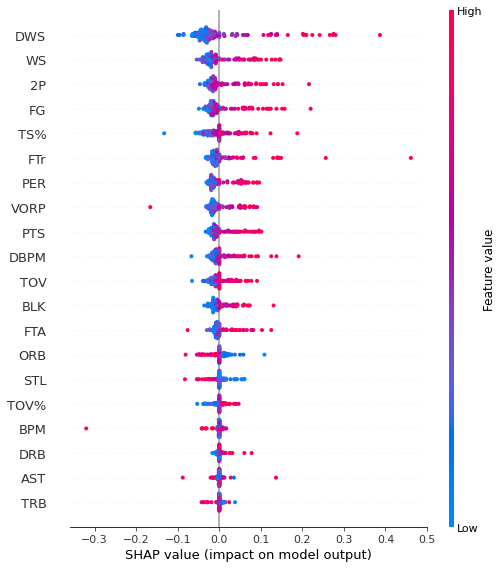

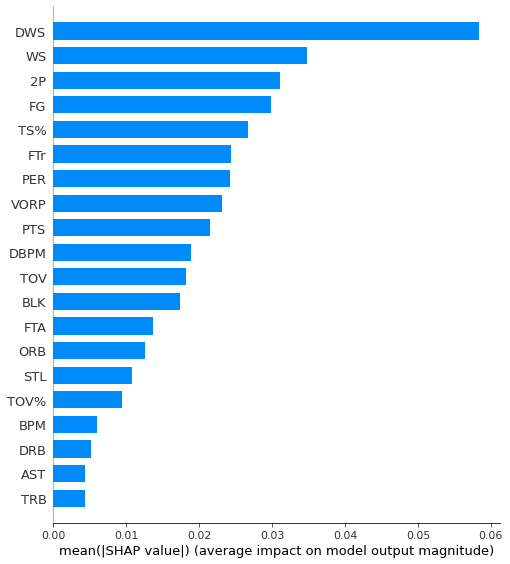

In [99]:
SHAP_values(svc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

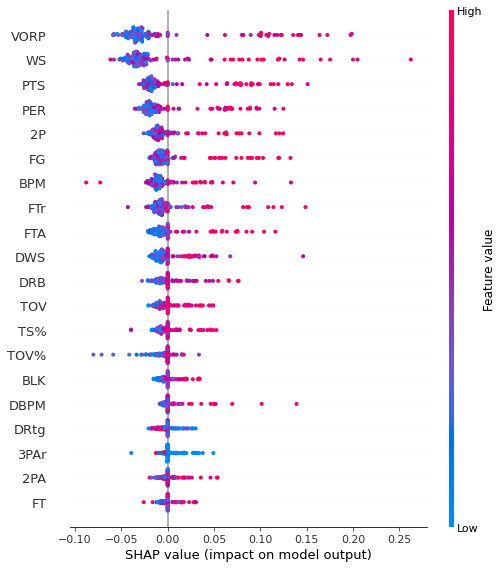

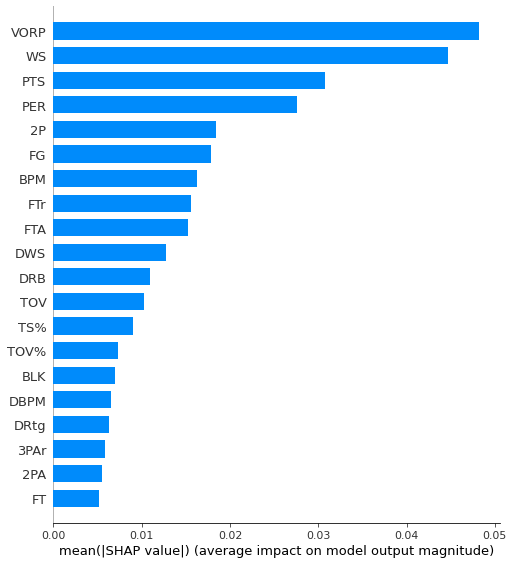

In [100]:
SHAP_values(rfc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

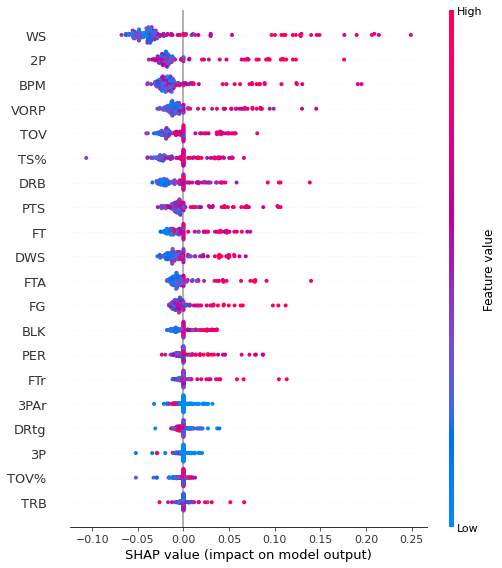

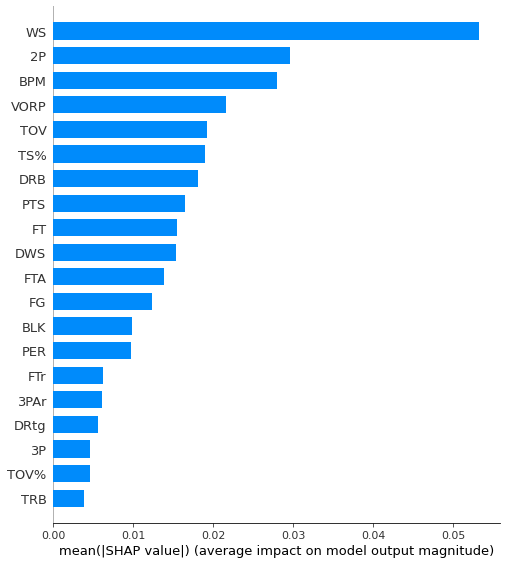

In [101]:
SHAP_values(gbc_undersampling, pd.DataFrame(data=X_train_undersampled, columns=feature_names))

In [102]:
# SHAP_values(svc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [103]:
# SHAP_values(rfc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [104]:
# SHAP_values(gbc_oversampling, pd.DataFrame(data=X_train_oversampled, columns=feature_names))

In [105]:
# SHAP_values(svc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

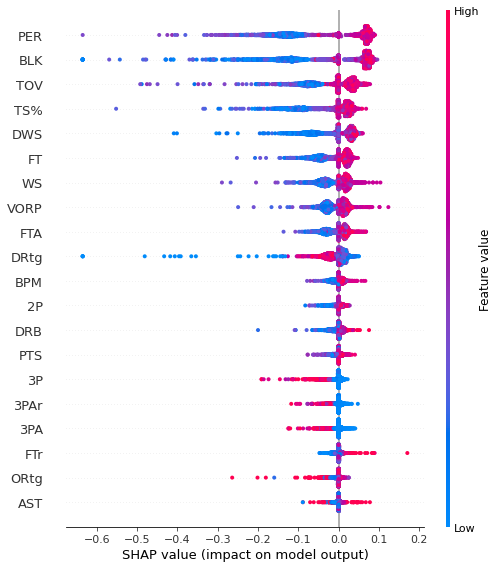

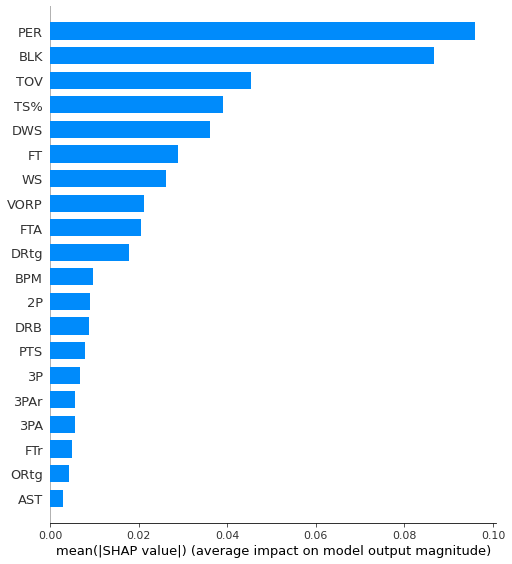

In [106]:
SHAP_values(rfc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))

In [107]:
# SHAP_values(gbc_smote, pd.DataFrame(data=X_train_resampled, columns=feature_names))